   По ссылке был предоставлен архив с тестовыми и тренировочными данными измерений приборов в скважинах - отдельный файл для каждой скважины.

Измерения представляют из себя векторные time series по глубине скважины с постоянным периодом дискретизации. Измерения представлены следующими мнемониками: SP, GR, DT, Dens. В тренировочном наборе присутствуют также метки - предсказания признаков коллектора (**Litho**).

Стандартная задача - создать предиктивную модель и предоставить предсказания на тестовом наборе, а также ноутбук с решением.

Предпочтительно сделать предсказания с использованием нейронных сетей. Keras - хорошо. tensorflow, pytorch - отлично. Конкретные модели и архитектуры на твой выбор.

Если что-то будет работать лучше НС - тоже хорошо.
 
Данные предоставлены в формате LAS (http://www.cwls.org/las/). Для считывания рекомендуем пользоваться библиотекой lasio (https://github.com/kinverarity1/lasio).


SP - спонтанная поляризация, GR - гамма-каротаж, DT - акустический каротаж , Dens - плотностной каротаж.
 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio
import os

import seaborn as sns
sns.set(style="ticks")

%matplotlib inline
plt.style.use("ggplot")

import tensorflow as tf

from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold #StratifiedKFOLD for uinique holes cv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score,auc,roc_curve

from itertools import cycle 

from __future__ import division, print_function

from tqdm import tqdm
from tqdm import trange
import scipy


/home/konstantin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/konstantin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(1)

# 1. Постановка задачи и мера качества
* задача бинарной классификации
* метрика: F-мера

# 2. Понимание и предобработка данных, формирование матрицы объекты-признаки

In [5]:
### Подсчёт числа файлов в train и test
DIR = 'train'
print("At train: {}".format(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])))
DIR = 'test'
print("At test: {}".format(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])))


At train: 792
At test: 264


In [6]:
#посмотрим на измерения некоторой приборов некоторой скважины
temp = lasio.read("train/208-902.las")
temp.keys()

Header section Parameter regexp=~P was not found.


['DEPT', 'SP', 'GR', 'DT', 'DENS', 'LITHO']

In [7]:
temp.curves

[CurveItem(mnemonic=DEPT, unit=m, value=, descr=, original_mnemonic=DEPT, data.shape=(186,)),
 CurveItem(mnemonic=SP, unit=, value=, descr=, original_mnemonic=SP, data.shape=(186,)),
 CurveItem(mnemonic=GR, unit=, value=, descr=, original_mnemonic=GR, data.shape=(186,)),
 CurveItem(mnemonic=DT, unit=, value=, descr=, original_mnemonic=DT, data.shape=(186,)),
 CurveItem(mnemonic=DENS, unit=, value=, descr=, original_mnemonic=DENS, data.shape=(186,)),
 CurveItem(mnemonic=LITHO, unit=, value=, descr=, original_mnemonic=LITHO, data.shape=(186,))]

In [8]:
temp.data

array([[ 2.50760000e+03, -5.40843506e+01,  1.16443085e+02,
         2.98420380e+02,  2.35712840e+00,  0.00000000e+00],
       [ 2.50770000e+03, -5.58703537e+01,  1.16065895e+02,
         2.98481506e+02,  2.35882930e+00,  0.00000000e+00],
       [ 2.50780000e+03, -5.67645874e+01,  1.15641624e+02,
         2.98433319e+02,  2.36065890e+00,  0.00000000e+00],
       ...,
       [ 2.52590000e+03, -9.65775833e+01,  7.42667465e+01,
         3.20401520e+02,  2.31691150e+00,  1.00000000e+00],
       [ 2.52600000e+03, -8.76874924e+01,  8.78272934e+01,
         3.12748749e+02,  2.33059360e+00,  1.00000000e+00],
       [ 2.52610000e+03, -7.86500244e+01,  1.00438805e+02,
         3.05604004e+02,  2.34324910e+00,  0.00000000e+00]])

In [9]:
del temp

Предполагаем, что скважины независимы друг от друга.

In [ ]:
#Посчитаем количество измерений по каждой тренировочной скважине
train_obs_count = []

DIR = "train"
files = [f for f in os.listdir(DIR) if os.path.isfile(os.path.join(DIR,f))]

for f in files:
    filename, ext = os.path.splitext(DIR+"/"+f)
    
    if ext == '.las':
        hole = lasio.read(DIR+"/"+f).data
        train_obs_count.append(hole.shape[0])

train_obs_count = np.array(train_obs_count)

#Посчитаем количество измерений по каждой тестовой скважине
test_obs_count = []

DIR = "test"
files = [f for f in os.listdir(DIR) if os.path.isfile(os.path.join(DIR,f))]

for f in files:
    hole = lasio.read(DIR+"/"+f).data
    filename, ext = os.path.splitext(DIR+"/"+f)
    
    if ext == '.las':
        test_obs_count.append(hole.shape[0])

test_obs_count = np.array(test_obs_count)

In [11]:
print(np.mean(train_obs_count))
print(np.min(train_obs_count))

203.30429292929293
82


In [12]:
print(np.mean(test_obs_count))
print(np.min(test_obs_count))

197.6780303030303
83


In [13]:
"""
#количество предыдущих измерений (на меньшой глубине)
с датчиков для данного измерения,то на сколько мы смотрим назад. 
"""
LOOK_BACK = 6 
#Этот гиперпараметр настроен

In [ ]:
"""
Объединим все тренировочные измерения по скважинам и
добавим в выборку приращения показаний датчиков, расположенных на разной глубине (LOOK_BACK)
"""
DIR = "train"
files = [f for f in os.listdir(DIR) if os.path.isfile(os.path.join(DIR,f))]

merged = []

for f in files:
    filename, ext = os.path.splitext(DIR+"/"+f)
    
    if ext == '.las':
        hole = lasio.read(DIR+"/"+f).data
        hole = pd.DataFrame(hole,columns=['DEPT', 'SP', 'GR', 'DT', 'DENS', 'LITHO'])
        hole["ID"] = [filename]*hole.shape[0] #id скважины, чтобы отличать одну скважину от другой
        
        #вычисления приращений показаний датчиков, расположенных на разной глубине
        for i in range(1,LOOK_BACK+1):
            temp = hole.shift(periods=i)[['SP', 'GR', 'DT', 'DENS']]
            temp = temp.rename(columns={"SP":"SP_diff_{}".format(i),"GR":"GR_diff_{}".format(i),"DT":"DT_diff_{}".format(i),"DENS":"DENS_diff_{}".format(i)})

            hole = pd.concat([hole,temp],1)
            del temp
            
            for col,col_ti in zip(['SP', 'GR', 'DT', 'DENS'],\
                                 ["SP_diff_{}".format(i),"GR_diff_{}".format(i),"DT_diff_{}".format(i),"DENS_diff_{}".format(i)]):
                hole[col_ti]=hole[col].values - hole[col_ti].values

        merged.append(hole)

train = pd.concat(merged)

"""
#соответствует первым измерениям по данной скважине, для которых нет информации о том, какие значения датчиков были на
предыдущей глубине, поэтому полагаем такие приращение, равными нулю
"""
train = train.fillna(0) 

In [15]:
train.shape

(161017, 31)

In [ ]:
"""
Объединим все тестовые измерения по скважинам и
добавим в выборку приращения показаний датчиков, расположенных на разной глубине (LOOK_BACK)
"""
DIR = "test"
files = [f for f in os.listdir(DIR) if os.path.isfile(os.path.join(DIR,f))]

merged = []

for f in files:
    filename, ext = os.path.splitext(DIR+"/"+f)
    
    if ext == '.las':
        hole = lasio.read(DIR+"/"+f).data
        hole = pd.DataFrame(hole,columns=['DEPT', 'SP', 'GR', 'DT', 'DENS'])
        hole["ID"] = [filename]*hole.shape[0] #id скважины, чтобы отличать одну скважину от другой
        
        #вычисления приращений датчиков, расположенных на разной глубине
        for i in range(1,LOOK_BACK+1):
            temp = hole.shift(periods=i)[['SP', 'GR', 'DT', 'DENS']]
            temp = temp.rename(columns={"SP":"SP_diff_{}".format(i),"GR":"GR_diff_{}".format(i),"DT":"DT_diff_{}".format(i),"DENS":"DENS_diff_{}".format(i)})

            hole = pd.concat([hole,temp],1)
            del temp
            
            for col,col_ti in zip(['SP', 'GR', 'DT', 'DENS'],\
                                 ["SP_diff_{}".format(i),"GR_diff_{}".format(i),"DT_diff_{}".format(i),"DENS_diff_{}".format(i)]):
                hole[col_ti]=hole[col].values - hole[col_ti].values

        merged.append(hole)

"""
#соответствует первым измерениям по данной скважине, для которых нет информации о том, какие значения датчиков были на
предыдущей глубине, поэтому полагаем такие приращения, равными нулю
"""
test = pd.concat(merged)
test = test.fillna(0)

In [17]:
test.shape

(52187, 30)

In [18]:
train.describe()

,DEPT,SP,GR,DT,DENS,LITHO,SP_diff_1,GR_diff_1,DT_diff_1,DENS_diff_1,...,DT_diff_4,DENS_diff_4,SP_diff_5,GR_diff_5,DT_diff_5,DENS_diff_5,SP_diff_6,GR_diff_6,DT_diff_6,DENS_diff_6
count,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,...,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000,161017.000000
mean,2513.805211,-77.560713,90.766795,307.244534,2.342055,0.325997,-0.148353,-0.103094,0.050199,-0.000093,...,0.201054,-0.000370,-0.730773,-0.509463,0.252343,-0.000464,-0.872181,-0.609598,0.304074,-0.000559
std,9.458460,27.573558,19.798213,11.657857,0.022118,0.468747,4.500126,4.485105,2.810092,0.005410,...,9.022778,0.017360,18.741535,16.278746,10.183242,0.019585,21.007842,17.573828,10.983396,0.021113
min,2485.500000,-125.710487,57.918972,283.392731,2.295403,0.000000,-15.719635,-15.487961,-10.825775,-0.022723,...,-36.174744,-0.067774,-63.416245,-50.069695,-40.253815,-0.072753,-70.100220,-52.962589,-41.313812,-0.078094
25%,2507.400000,-102.506989,71.531837,297.917725,2.323919,0.000000,-2.712296,-2.260788,-1.210815,-0.002605,...,-4.158844,-0.009110,-11.380589,-9.365486,-4.769165,-0.010468,-12.836800,-10.243286,-5.155701,-0.011420
50%,2514.700000,-73.120529,93.192543,303.358490,2.348971,0.000000,-0.033936,-0.012482,0.007996,-0.000013,...,0.000000,0.000000,-0.029083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2520.900000,-52.380955,110.966972,316.796326,2.359646,1.000000,2.377640,2.060944,1.330109,0.002402,...,4.613190,0.008243,9.933304,8.092476,5.303589,0.009389,11.099625,8.729324,5.783752,0.010213
max,2543.700000,-39.054886,116.989639,330.196503,2.390461,1.000000,14.872345,14.507980,11.493866,0.021669,...,37.544281,0.068694,60.985741,50.200973,40.222534,0.077487,67.808670,53.130203,42.475403,0.082420


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161017 entries, 0 to 351
Data columns (total 31 columns):
DEPT           161017 non-null float64
SP             161017 non-null float64
GR             161017 non-null float64
DT             161017 non-null float64
DENS           161017 non-null float64
LITHO          161017 non-null float64
ID             161017 non-null object
SP_diff_1      161017 non-null float64
GR_diff_1      161017 non-null float64
DT_diff_1      161017 non-null float64
DENS_diff_1    161017 non-null float64
SP_diff_2      161017 non-null float64
GR_diff_2      161017 non-null float64
DT_diff_2      161017 non-null float64
DENS_diff_2    161017 non-null float64
SP_diff_3      161017 non-null float64
GR_diff_3      161017 non-null float64
DT_diff_3      161017 non-null float64
DENS_diff_3    161017 non-null float64
SP_diff_4      161017 non-null float64
GR_diff_4      161017 non-null float64
DT_diff_4      161017 non-null float64
DENS_diff_4    161017 non-null floa

In [20]:
test.describe()

,DEPT,SP,GR,DT,DENS,SP_diff_1,GR_diff_1,DT_diff_1,DENS_diff_1,SP_diff_2,...,DT_diff_4,DENS_diff_4,SP_diff_5,GR_diff_5,DT_diff_5,DENS_diff_5,SP_diff_6,GR_diff_6,DT_diff_6,DENS_diff_6
count,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,...,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000,52187.000000
mean,2513.908686,-77.712315,90.644875,307.213054,2.342147,-0.162636,-0.113590,0.053065,-0.000099,-0.322932,...,0.213428,-0.000406,-0.790217,-0.543400,0.268202,-0.000513,-0.941385,-0.650013,0.323496,-0.000621
std,9.135800,27.617159,19.823132,11.717488,0.022268,4.464719,4.435584,2.778167,0.005371,8.642594,...,8.918041,0.017226,18.611873,16.111417,10.065870,0.019429,20.874200,17.404020,10.859692,0.020942
min,2485.100000,-125.620000,57.799000,283.820000,2.295900,-15.355000,-15.344000,-11.480000,-0.020400,-29.033000,...,-35.600000,-0.069000,-59.601000,-49.573000,-38.400000,-0.074700,-66.499000,-52.675000,-40.410000,-0.080200
25%,2507.900000,-102.685000,71.359500,297.890000,2.323700,-2.713000,-2.220000,-1.190000,-0.002600,-5.270000,...,-4.070000,-0.009200,-11.500500,-9.181500,-4.730000,-0.010500,-12.996500,-10.140000,-5.070000,-0.011500
50%,2514.600000,-73.343000,93.090000,303.260000,2.349200,-0.043000,-0.018000,0.010000,0.000000,-0.075000,...,0.000000,0.000000,-0.052000,-0.023000,0.000000,0.000000,-0.040000,0.000000,0.000000,0.000000
75%,2520.800000,-52.545000,110.900000,316.875000,2.359800,2.334500,1.996500,1.300000,0.002400,4.542000,...,4.540000,0.008200,9.782500,7.762500,5.250000,0.009400,11.020000,8.511000,5.760000,0.010200
max,2540.100000,-38.943000,116.920000,329.980000,2.389900,14.820000,14.044000,11.270000,0.021000,28.053000,...,35.740000,0.068400,59.612000,49.184000,37.220000,0.078900,66.421000,52.973000,40.010000,0.083100


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52187 entries, 0 to 121
Data columns (total 30 columns):
DEPT           52187 non-null float64
SP             52187 non-null float64
GR             52187 non-null float64
DT             52187 non-null float64
DENS           52187 non-null float64
ID             52187 non-null object
SP_diff_1      52187 non-null float64
GR_diff_1      52187 non-null float64
DT_diff_1      52187 non-null float64
DENS_diff_1    52187 non-null float64
SP_diff_2      52187 non-null float64
GR_diff_2      52187 non-null float64
DT_diff_2      52187 non-null float64
DENS_diff_2    52187 non-null float64
SP_diff_3      52187 non-null float64
GR_diff_3      52187 non-null float64
DT_diff_3      52187 non-null float64
DENS_diff_3    52187 non-null float64
SP_diff_4      52187 non-null float64
GR_diff_4      52187 non-null float64
DT_diff_4      52187 non-null float64
DENS_diff_4    52187 non-null float64
SP_diff_5      52187 non-null float64
GR_diff_5      52187

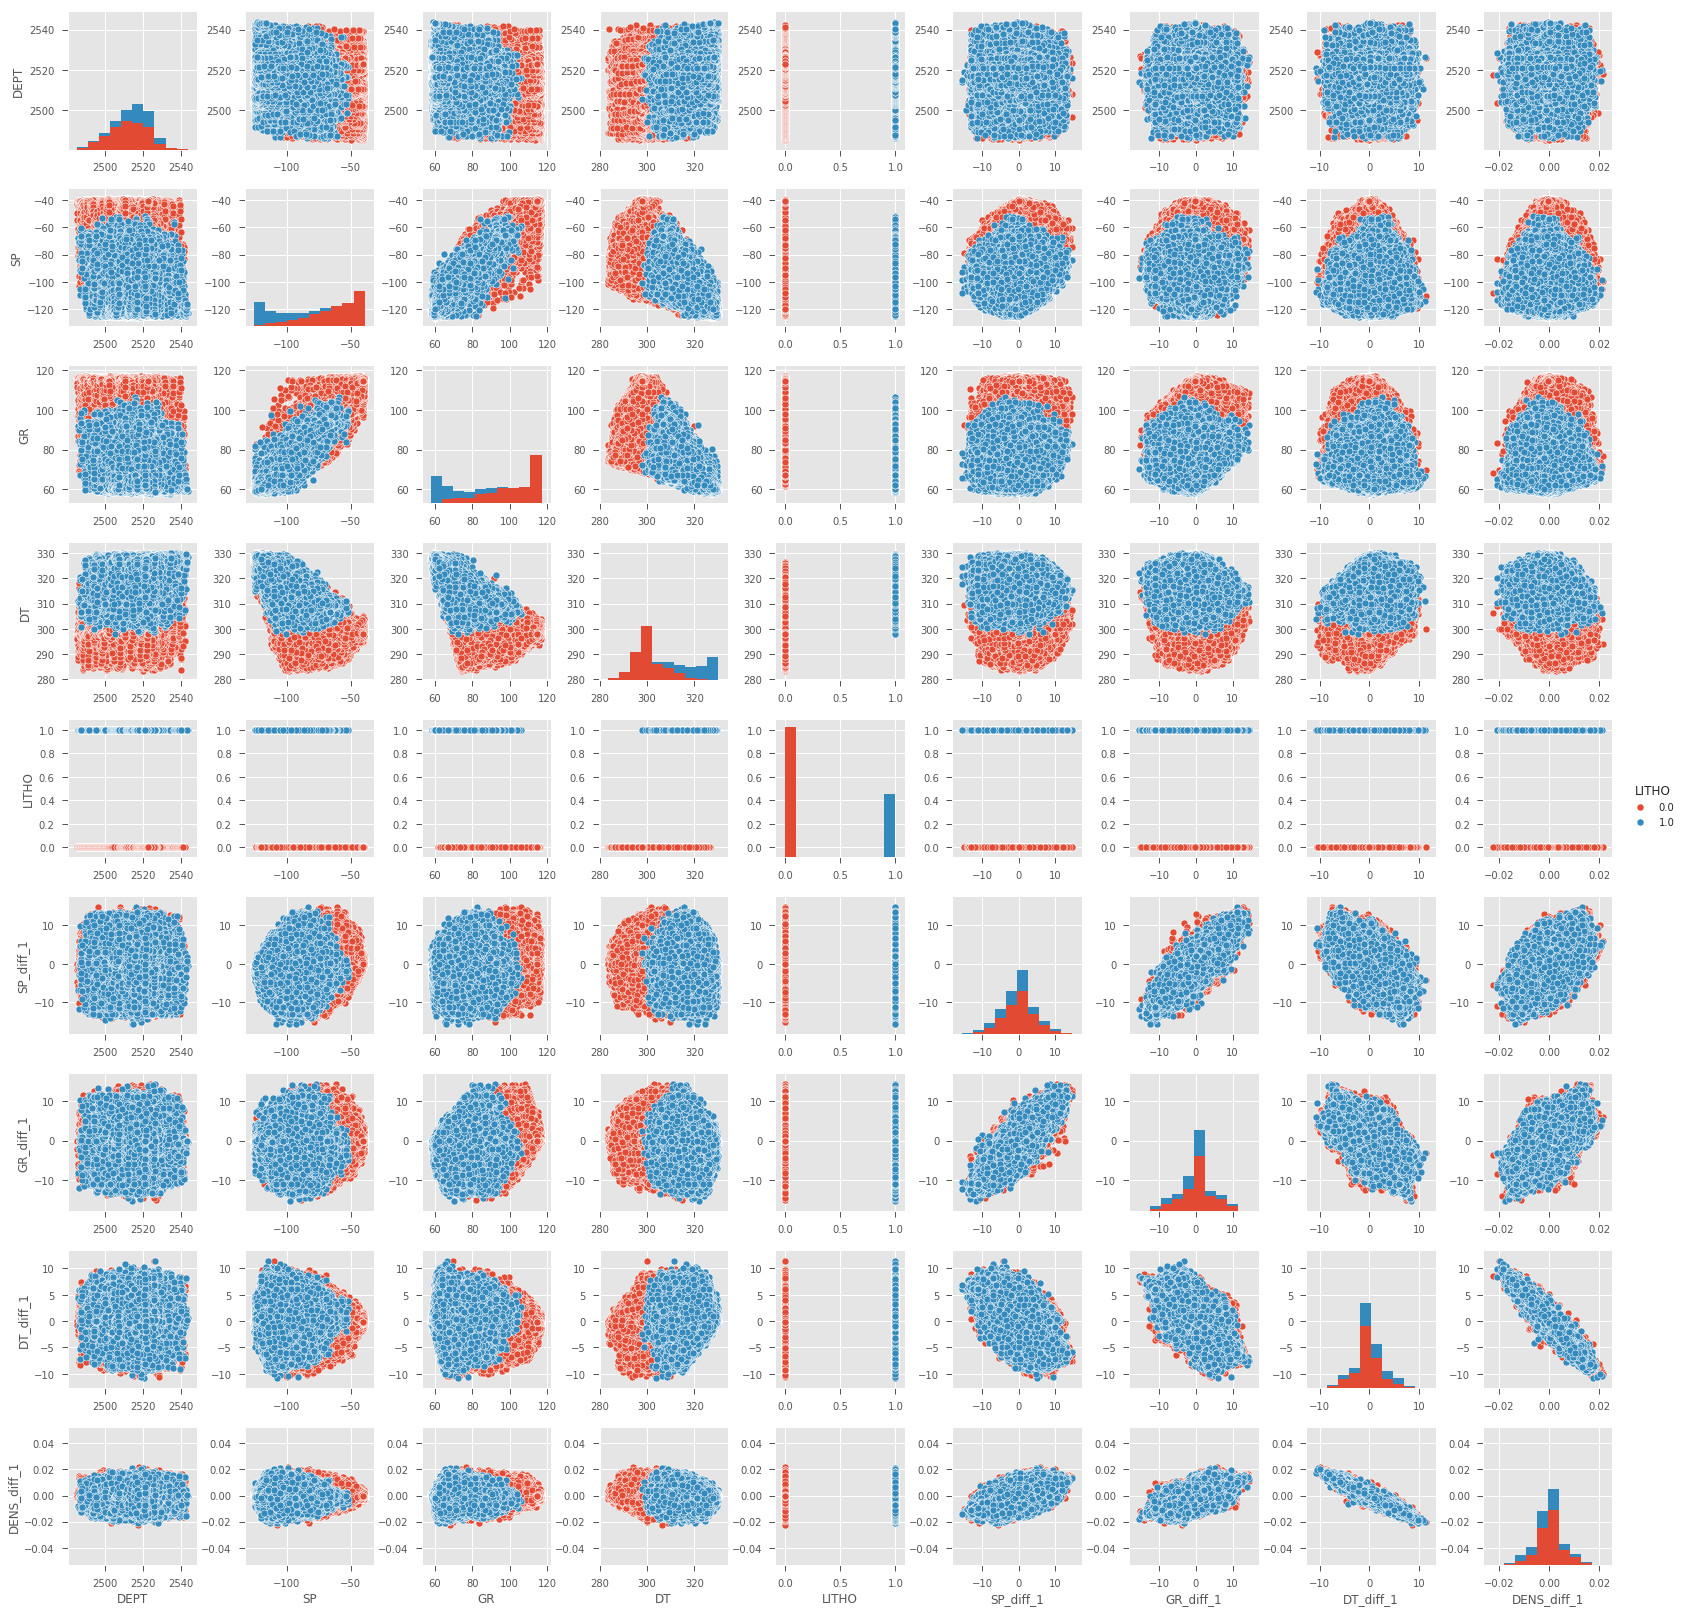

In [36]:
#Scatterplot Matrix for train 
sns.pairplot(train[["DEPT","SP","GR","DT","LITHO","SP_diff_1","GR_diff_1","DT_diff_1","DENS_diff_1"]], hue="LITHO") #для визуального анализа данных

In [ ]:
#Scatterplot Matrix for test
#sns.pairplot(test.drop("ID",1))

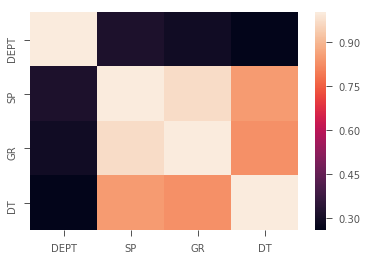

In [22]:
#матрица корреляций Пирсона
sns.heatmap(abs(train[["DEPT","SP","GR","DT"]].corr()))

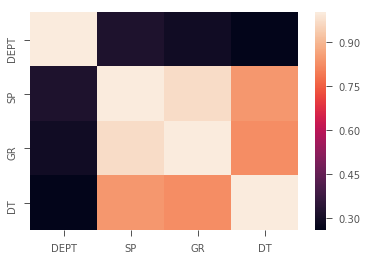

In [23]:
sns.heatmap(abs(test[["DEPT","SP","GR","DT"]].corr()))

### Определение выбросов в данных
Замечание:

**эвристика** -- выбросы лежат за пределами сегмента

$$
[Q_1 - 1.5IQR,Q_3 + 1.5IQR],
$$
где $Q_1$ -- первая квартиль:  $\frac{1}{l}\sum\limits_{i=1}^{l}[x^j_i \le Q_1] = 25 \% $;
$Q_3$ -- третья квартиль:  $\frac{1}{l}\sum\limits_{i=1}^{l}[x^j_i \le Q_3] = 75 \% $;

$IQR = Q_3 - Q_1$ -- интерквартильный размах

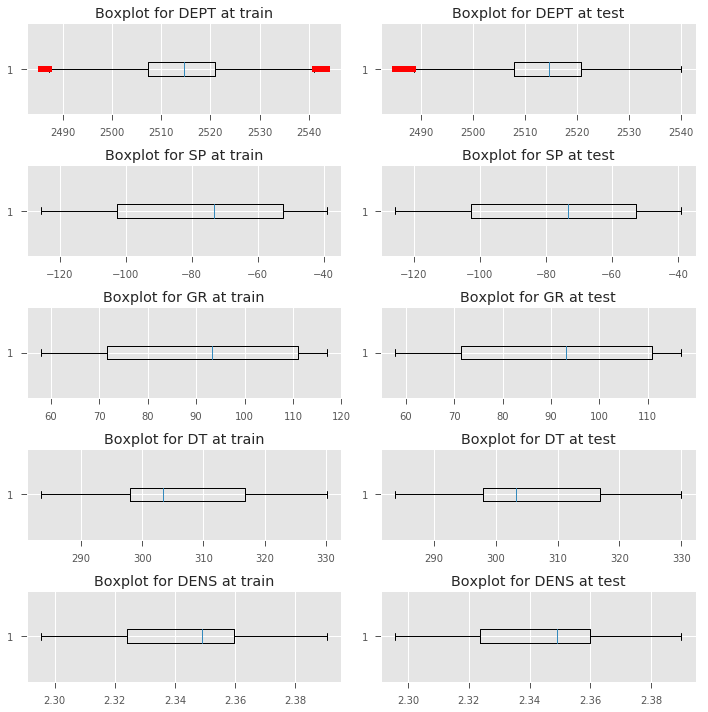

In [24]:
#Определение выбросов в признаках с помощью определеннной выше эвристики
#Будем строить ящик с усами(boxplot) для каждого признака для определения выбросов
#Хвосты ящика с усами соответствуют началу и концу определенного выше сегмента

fig, axes = plt.subplots(nrows = 5, ncols=2,figsize=(10,10))
for col,i in zip(['DEPT', 'SP', 'GR', 'DT', 'DENS'],range(5)):
    axes[i][0].boxplot(train[col], 0, 'rs',  0)
    axes[i][0].set_title("Boxplot for {} at train".format(col))

    axes[i][1].boxplot(test[col], 0, 'rs',  0)
    axes[i][1].set_title("Boxplot for {} at test".format(col))
    
fig.tight_layout();

**Красные точки -- это выбросы по данному признаку.**

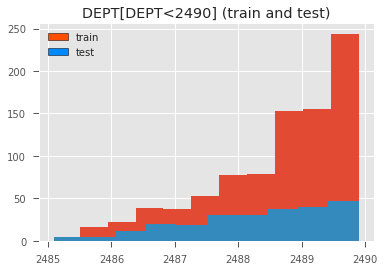

In [25]:
#Посмотрим на распределение измерений на глубине, меньшей, чем 2490 м
train.DEPT[train["DEPT"]<2490].hist()
test.DEPT[test["DEPT"]<2490].hist()
plt.title("DEPT[DEPT<2490] (train and test)")

#для нанесения легенды
from matplotlib.patches import Rectangle
cmap = plt.get_cmap('jet')
red = cmap(0.825)
blue =cmap(0.26)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [red,blue]]
labels= ["train","test"]
plt.legend(handles, labels)

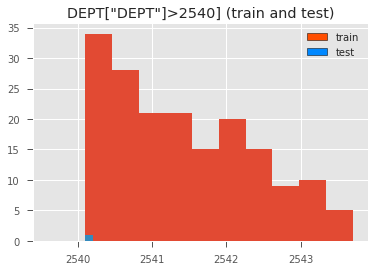

In [26]:
#Посмотрим на распределение измерений на глубине, большей, чем 2490 м
train.DEPT[train["DEPT"]>2540].hist()
test.DEPT[test["DEPT"]>2540].hist()
plt.title("DEPT[\"DEPT\"]>2540] (train and test)")
#create legend
from matplotlib.patches import Rectangle
cmap = plt.get_cmap('jet')
red = cmap(0.825)
blue =cmap(0.26)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [red,blue]]
labels= ["train","test"]
plt.legend(handles, labels)

**В тестовой выборке почти нет измерений на глубине, большей, чем 2540 м, поэтому в дальнейшием исключим такие измерения из тренировочной выборки.**

In [27]:
train["LITHO"].value_counts()

0.0    108526
1.0     52491
Name: LITHO, dtype: int64

In [28]:
np.round(100*train[train["LITHO"]==0].shape[0]/train.shape[0],1)

67.4

In [29]:
np.round(100*train[train["LITHO"]==1].shape[0]/train.shape[0],1)

32.6

Из-за неравномерной разметки тренировочной выборки явно на метрику accuracy(доля правильных ответов) нельзя смотреть, а нужно смотреть с учётом *BaseRate* (базовая доля правильных ответов):

$$ BaseRate = \underset{y_0\in\{0,1\}}{\arg\max}\frac{1}{l}\sum_{i=1}^{l}[y_0=y_i]$$

In [30]:
#Hold-Out by unique IDs
#Для обучения модели возьмём 75% процентов случайных скважин, а для валидации 25% процентов случайных скважин 
unique_train, unique_valid = train_test_split(np.unique(train["ID"]),test_size=0.25,shuffle=True,random_state=1)

In [31]:
#Исключим измерения на глубине, большей, чем 2540 м, из тренировочной выборки.
train_drop_outl=train[train["DEPT"]<=2540]

tr = train_drop_outl[train_drop_outl["ID"].isin(unique_train)]
Xtr = tr.drop(["ID","LITHO"],1).values
ytr = tr["LITHO"].values
del tr

val =train_drop_outl[train_drop_outl["ID"].isin(unique_valid)]
Xval = val.drop(["ID","LITHO"],1).values
yval = val["LITHO"].values
del val

print("Rate of 0,1-class objects at train: {}".format(np.unique(ytr,return_counts=True)[1]/len(ytr)))
print("Rate of 0,1-class objects at val: {}".format(np.unique(yval,return_counts=True)[1]/len(yval)))

Rate of 0,1-class objects at train: [0.6754735 0.3245265]
Rate of 0,1-class objects at val: [0.6714582 0.3285418]


$$BaseRate_{train}=67.5$$
$$BaseRate_{val}=67.1$$

In [32]:
#Масштабирование на выборочное среднее и стандартное отклонение 
ss = StandardScaler()
ss.fit(Xtr)
Xtr=ss.transform(Xtr)
Xval = ss.transform(Xval)

# 3. Построение модели и оценка её качества

Как упоминалсь ранее, оценка качества модели будет производиться на **Hold-Out уникальных скважин**.

## 3.1 Bayes Neural Network 
**(Bayes By Hypernet)** 
[Implicit Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1711.01297)

Почему байесовская нейронная сеть?

**Байесовская нейронная сеть устойчива к переобучению!**

В машинном обучении есть следующая простая техника — когда у вас есть несколько моделей, сопоставимых по качеству и слабо коррелируемых, можно взять и усреднить (или еще как-нибудь объединить) их предсказания, и тогда они могут работать хорошо вместе за счёт уменьшения разброса прогнозов.

В случае же байесовского подхода происходит усреднение достаточно большого кол-ва "моделей".

In [33]:
tf.test.is_gpu_available()

True

In [34]:
# функция, чтобы получить NN
def get_net(mode, ops, Xtr_shape, NUM_CLASSES=2, NEURON_NUMBER=800):
    with tf.variable_scope('net'):
        x = tf.placeholder(tf.float32, [None, Xtr_shape[1]])
        y = tf.placeholder(tf.int32, [None])
        
        ops['x'] = x
        ops['y'] = y
        
        if mode == 'implicit': # это соответствует статье "Implicit Weight Uncertainty in Neural Networks"
            g1 = ops['g1']
            g2 = ops['g2']
            g3 = ops['g3']

            
            # layer 1
            v1 = tf.get_variable('v1', [Xtr_shape[1], NEURON_NUMBER], tf.float32, #NEURON_NUMBER is число нейронов в слое
                                tf.random_normal_initializer(0, 0.05))
            
            x = tf.matmul(x, v1)
            
            b1 = tf.get_variable('b1', [NEURON_NUMBER], tf.float32, tf.constant_initializer()) #смещение
            
            scaler = g1 / tf.sqrt(tf.reduce_sum(tf.square(v1),[0]))
            x = tf.reshape(scaler,[1, NEURON_NUMBER])*x + tf.reshape(b1, [1, NEURON_NUMBER])
            x = tf.nn.relu(x)
            
            # layer 2
            v2 = tf.get_variable('v2', [NEURON_NUMBER, NEURON_NUMBER], tf.float32,
                                tf.random_normal_initializer(0, 0.05))
            
            x = tf.matmul(x, v2)
            
            b2 = tf.get_variable('b2', [NEURON_NUMBER], tf.float32, tf.constant_initializer())
            
            scaler = g2 / tf.sqrt(tf.reduce_sum(tf.square(v2),[0]))
            x = tf.reshape(scaler,[1, NEURON_NUMBER])*x + tf.reshape(b2, [1, NEURON_NUMBER])
            x = tf.nn.relu(x)
            
            # layer 3
            v3 = tf.get_variable('v3', [NEURON_NUMBER, NUM_CLASSES], tf.float32, 
                                tf.random_normal_initializer(0, 0.05))
            
            x = tf.matmul(x, v3)
            
            b3 = tf.get_variable('b3', [NUM_CLASSES], tf.float32, tf.constant_initializer()) 
            
            scaler = g3 / tf.sqrt(tf.reduce_sum(tf.square(v3),[0]))
            x = tf.reshape(scaler,[1, NUM_CLASSES])*x + tf.reshape(b3, [1, NUM_CLASSES])

        ops['logits'] = x
        
        return ops
        


In [35]:
# hypernetwork, чтобы генерить веса (генеративная модель)
def get_h_net(units=[64, 256], num_noise=29,NUM_CLASSES=2,NEURON_NUMBER=800):
    with tf.variable_scope('h_net'):
        # auxiliary conditioning
        w1_c = tf.constant([1., 0., 0.])
        w2_c = tf.constant([0., 1., 0.])
        w3_c = tf.constant([0., 0., 1.])

        #auxiliary noise
        noise = tf.random_normal((num_noise, ))

        w1_z = tf.reshape(tf.concat([w1_c, noise], 0), (1, num_noise + 3))
        w2_z = tf.reshape(tf.concat([w2_c, noise], 0), (1, num_noise + 3))
        w3_z = tf.reshape(tf.concat([w3_c, noise], 0), (1, num_noise + 3))
        
        w_z = tf.concat([w1_z, w2_z, w3_z], 0)
        
        z = w_z
        
        for unit in units:
            z = tf.layers.dense(inputs=z, units=unit)
            z = tf.nn.elu(z)
        
        z = tf.layers.dense(inputs=w_z, units=NEURON_NUMBER)

        w1 = z[0, :]
        w2 = z[1, :]

        w3 = z[2, :NUM_CLASSES]
        
        return [w1, w2, w3, tf.reshape(tf.concat([w1, w2, w3], 0), (2*NEURON_NUMBER+NUM_CLASSES, 1))]


In [36]:
#дискриминативная модель
def get_d_net(gens, units=[20, 20],NUM_CLASSES=2,NEURON_NUMBER=800):
    with tf.variable_scope('d_net'):
        
        ds = tf.contrib.distributions
        mix = 0.7
        bimix_gauss = ds.Mixture(
          cat=ds.Categorical(probs=[mix, 1.-mix]),
          components=[
            ds.Normal(loc=0., scale=0.01),
            ds.Normal(loc=0., scale=5.),
        ])
        
        noise = bimix_gauss.sample((NEURON_NUMBER + NEURON_NUMBER + NUM_CLASSES, 1))
        
        all_t = tf.concat((gens, noise), 0)
        
        d = all_t
        
        for unit in units:
            d = tf.layers.dense(inputs=d, units=unit )
            d = tf.nn.relu(d)
        
        d = tf.layers.dense(inputs=d, units=1)
        
        return d[:NEURON_NUMBER + NEURON_NUMBER +NUM_CLASSES], d[NEURON_NUMBER + NEURON_NUMBER +NUM_CLASSES:]

In [37]:
num_noise = 125

layers = [64, 256]

mode = 'implicit'

batch_size = 128

tf.reset_default_graph()

ops = {}

if mode == 'implicit':
    w1, w2, w3, gens = get_h_net(num_noise=num_noise, units=layers)

    g_d, n_d = get_d_net(gens)

    ops = {'g1': w1, 'g2': w2, 'g3': w3}

    d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'd_net')
    g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'h_net')

# get network ops
ops = get_net(mode, ops, Xtr_shape=np.array(Xtr.shape).astype(np.int32))

net_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'net')

# оптимизируемая функция потерь -- log-loss
ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=ops['logits'], labels=ops['y']))

# метод оптимизации
opt = tf.train.AdamOptimizer(0.001,epsilon=1e-5)

if mode == 'implicit':
    loss_d = (- tf.reduce_mean(tf.log(1 - tf.nn.sigmoid(n_d) + 1e-8, name='log_n_d'))
              - tf.reduce_mean(tf.log(tf.nn.sigmoid(g_d) + 1e-8, name='log_g_d')))

    gvs = opt.compute_gradients(loss_d, var_list=d_vars)
    capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs if grad is not None]
    d_optimiser = opt.apply_gradients(capped_gvs)

    g_logits_m = tf.reduce_mean(g_d)

    loss_g = g_logits_m + len(ytr) / float(batch_size) * ce

    g_optimiser = opt.minimize(loss_g, var_list=g_vars+net_vars)

    d_n_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(n_d) < 0.5, tf.float32))
    d_g_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(g_d) >= 0.5, tf.float32))


# Функция, хранящая предсказания 
pred = tf.argmax(ops['logits'], -1, output_type=tf.int32)

# Тензор, чтобы вычислить точность предсказаний
acc = tf.reduce_mean(tf.cast(tf.equal(pred, ops['y']), tf.float32))

probs = tf.nn.softmax(ops['logits'])

# для инициализации переменных
init = tf.global_variables_initializer()

numerics = tf.add_check_numerics_ops()

In [38]:
# адаптированная под специфику данной задачи метод tensorflow -- next_batch
def next_batch(data:"np array", labels:"np array", batch_size:int, shuffle=False):
    
    #если наблюдения независимы, что в нашем случае НЕ ТАК
    if shuffle:
        # Shuffle data
        shuffle_indices = np.random.permutation(np.arange(len(labels)))
        data = data[shuffle_indices]
        labels = labels[shuffle_indices]

    for batch_i in range(0, len(data)//batch_size):
        start_i = batch_i * batch_size
        data_batch = data[start_i:start_i + batch_size]
        labels_batch = labels[start_i:start_i + batch_size]

        yield np.array(data_batch), np.array(labels_batch)

In [44]:
# генератор для циклического прохода по батчам
generator = cycle(next_batch(data=Xtr,labels=ytr,batch_size=batch_size))

s = tf.Session()

# Инициализация весов
s.run(init)

print("Xtrain shape: {}".format(Xtr.shape))
print("GPU: {}".format(tf.test.is_gpu_available()))

# Запуск дискриминатора, чтобы давать лучшие значения градиентов
if mode == 'implicit':
    for _ in range(300):
        s.run(d_optimiser)

with trange(200 * 400) as pbar: # проведём ~200 эпох (первый аргумент)
    for i in pbar:
        # получаем батч 
        b = batch_xs, batch_ys = next(generator) 
        
        if mode == 'implicit':
            #Запуск дискриминатора, чтобы давать лучшие значения градиентов
            for _ in range(20):
                s.run(d_optimiser)

            np_acc, d_loss, g_loss, l_loss, np_d, np_g, _, _ = s.run([acc, loss_d, g_logits_m, ce,
                                                                  d_n_acc, d_g_acc, g_optimiser, numerics],
                                                                 feed_dict={ops['x']: batch_xs,
                                                                            ops['y']: batch_ys})

            pbar.set_postfix(acc=np_acc, d_loss=d_loss, g_loss=g_loss,
                             l_loss=l_loss, d_n_acc=np_d, d_g_acc=np_g)
        elif mode == 'bbb':
            np_acc, l_loss, kl_loss, _ = s.run([acc, ce, ops['kl_loss'], optimiser],
                                      feed_dict={ops['x']: batch_xs, ops['y']: batch_ys})
            pbar.set_postfix(acc=np_acc, ce=l_loss, kl_loss=kl_loss)
        else:
            np_acc, l_loss, _ = s.run([acc, ce, optimiser],
                                      feed_dict={ops['x']: batch_xs, ops['y']: batch_ys})

            pbar.set_postfix(acc=np_acc, ce=l_loss)

Xtrain shape: (119377, 29)
GPU: True


100%|██████████| 80000/80000 [54:44<00:00, 24.51it/s, acc=1, d_g_acc=0.969, d_loss=0.657, d_n_acc=0.763, g_loss=1.48, l_loss=0.00803]    


In [45]:

NUM_CLASSES = 2
if mode == 'implicit' or mode == 'dropout' or mode == 'bbb':
    np_probs = np.zeros((len(yval), NUM_CLASSES))
    mc_steps = 300
    for _ in trange(mc_steps):
        np_probs += s.run(probs, feed_dict={ops['x']: Xval})
    np_probs /= mc_steps
else:
    np_probs = s.run(probs, feed_dict={ops['x']: Xval})

np_preds = np.argmax(np_probs, -1)
np_val_acc = np.mean(np_preds == yval)



100%|██████████| 300/300 [00:09<00:00, 30.50it/s]


In [46]:
#f1-score на валидационной выборке
print("Valid f1-score is {}".format(f1_score(yval,np_preds)))

#точность на валидационной выборке
print("Valid precision is {}".format(precision_score(yval,np_preds)))

#полнота на валидационной выборке
print("Valid recall is {}".format(recall_score(yval,np_preds)))

#доля правильных ответов на валидационной выборке
print('Valid accuracy is {}'.format(np_val_acc))


Valid f1-score is 0.964331537079805
Valid precision is 0.9630958482829318
Valid recall is 0.9655704008221994
Valid accuracy is 0.9765327287636872


* Valid f1-score is 0.88, LOOK_BACK = 1, trange(50 * 400)


* Valid f1-score is 0.9396, LOOK_BACK = 2, trange(50 * 400)


* Valid f1-score is 0.9575,  LOOK_BACK = 2, trange(300 * 400)


* Valid f1-score is 0.9488 , LOOK_BACK = 7, trange(50 * 400)


* Valid f1-score is 0.9456, LOOK_BACK = 10, trange(50 * 400)


* Valid f1-score is 0.9643, LOOK_BACK = 6, trange(200 * 400)


* **Valid f1-score is 0.9649, LOOK_BACK = 6, trange(1000 * 600)**



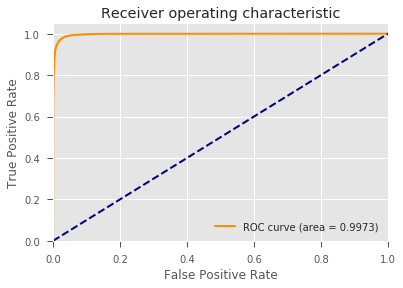

In [47]:
# roc-кривая и площадь под ней на валидационной выборке
fpr,tpr,_ = roc_curve(yval, np_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ROC-кривая не изменится при перемене соотношения между классами

## 3.2 Логистическая регрессия

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
log_reg = LogisticRegression(C=10)

In [41]:
log_reg.fit(Xtr,ytr)
print(f1_score(yval,log_reg.predict(Xval)))

0.9216508497020525


## 3.3 XGBoost

In [46]:
from xgboost import XGBClassifier

/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [47]:
%%time
xgb = XGBClassifier(n_estimators=1000,max_depth=6,learning_rate=0.05,\
                    subsample=0.5, colsample_bytree=0.85, colsample_bylevel=0.85,\
                    reg_alpha=0.5, reg_lambda=0.5,base_score=0.2,seed=0)
xgb.fit(Xtr,ytr)
print(f1_score(yval,xgb.predict(Xval)))

0.9585253456221199
CPU times: user 10min 6s, sys: 3.93 s, total: 10min 10s
Wall time: 1min 21s


/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGB results

f1 ~ 0.89,   LOOK_BACK = 1 

f1 ~ 0.9565, LOOK_BACK = 5

**f1 ~ 0.9585, LOOK_BACK = 6 **

f1 ~ 0.9578, LOOK_BACK = 7 

f1 ~ 0.948,  LOOK_BACK = 82



## 3.4 Catboost

In [71]:
from catboost import CatBoostClassifier

In [74]:
cat_boost = CatBoostClassifier(logging_level="Silent")

In [76]:
cat_boost.fit(Xtr,ytr)
print("f1-score:{}".format(f1_score(yval,cat_boost.predict(Xval))))

f1-score:0.948457376809475


## 3.5. Mixing of Bayes NN and XGBoost
Bayes NN: trange(1000 * 600)

In [123]:
f1_score(yval,np.argmax((0.46*np_probs +0.54*xgb.predict_proba(Xval)),-1))

0.9695339841591453

# 4. Построение прогноза

In [42]:
from copy import deepcopy

In [43]:
#Исключим измерения на глубине, большей, чем 2540 м, из тренировочной выборки.
train_drop_outl=train[train["DEPT"]<=2540]

X = train_drop_outl.drop(["ID","LITHO"],1).values
y = train_drop_outl["LITHO"].values
Xtest = test.drop(["ID"],1).values

#Масштабирование на выборочное среднее и стандартное отклонение 
ss = StandardScaler()
ss.fit(X)
X=ss.transform(X)
Xtest = ss.transform(Xtest)

Обучим теперь модели на всех тренировочных данных

In [48]:
#xgb
xgb.fit(X,y)
probas_xgb = xgb.predict_proba(Xtest)
preds_xgb = np.argmax(probas_xgb,-1)

In [49]:
test_xgb = deepcopy(test)
test_xgb["ID"] = test_xgb["ID"].astype(str)
test_xgb["LITHO"] = preds_xgb

In [157]:
#Save XGB predictions
DIR = "xgb_test"
for ID in np.unique(test_xgb[["ID"]].values):
    temp = test_xgb[test_xgb["ID"]==ID]
    temp[["DEPT","LITHO"]].to_csv(DIR+"/"+ID[5:]+".csv",index=False)
    del temp

In [50]:
#Bayes NN
num_noise = 125

layers = [64, 256]

mode = 'implicit'

batch_size = 128

tf.reset_default_graph()

ops = {}

if mode == 'implicit':
    w1, w2, w3, gens = get_h_net(num_noise=num_noise, units=layers)

    g_d, n_d = get_d_net(gens)

    ops = {'g1': w1, 'g2': w2, 'g3': w3}

    d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'd_net')
    g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'h_net')

# get network ops
ops = get_net(mode, ops, Xtr_shape=np.array(X.shape).astype(np.int32))

net_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'net')

# оптимизируемая функция потерь -- log-loss
ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=ops['logits'], labels=ops['y']))

# метод оптимизации
opt = tf.train.AdamOptimizer(0.001,epsilon=1e-5)

if mode == 'implicit':
    loss_d = (- tf.reduce_mean(tf.log(1 - tf.nn.sigmoid(n_d) + 1e-8, name='log_n_d'))
              - tf.reduce_mean(tf.log(tf.nn.sigmoid(g_d) + 1e-8, name='log_g_d')))

    gvs = opt.compute_gradients(loss_d, var_list=d_vars)
    capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs if grad is not None]
    d_optimiser = opt.apply_gradients(capped_gvs)

    g_logits_m = tf.reduce_mean(g_d)

    loss_g = g_logits_m + len(y) / float(batch_size) * ce

    g_optimiser = opt.minimize(loss_g, var_list=g_vars+net_vars)

    d_n_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(n_d) < 0.5, tf.float32))
    d_g_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(g_d) >= 0.5, tf.float32))


# Функция, хранящая предсказания 
pred = tf.argmax(ops['logits'], -1, output_type=tf.int32)

# Тензор, чтобы вычислить точность предсказаний
acc = tf.reduce_mean(tf.cast(tf.equal(pred, ops['y']), tf.float32))

probs = tf.nn.softmax(ops['logits'])

# для инициализации переменных
init = tf.global_variables_initializer()

numerics = tf.add_check_numerics_ops()

# генератор для циклического прохода по батчам
generator = cycle(next_batch(data=X,labels=y,batch_size=batch_size))

s = tf.Session()

# Инициализация весов
s.run(init)

print("Xtrain shape: {}".format(X.shape))
print("GPU: {}".format(tf.test.is_gpu_available()))

# Запуск дискриминатора, чтобы давать лучшие значения градиентов
if mode == 'implicit':
    for _ in range(300):
        s.run(d_optimiser)

with trange(1000 * 600) as pbar: # проведём ~ n эпох (первый аргумент)
    for i in pbar:
        # получаем батч 
        b = batch_xs, batch_ys = next(generator) 
        
        if mode == 'implicit':
            #Запуск дискриминатора, чтобы давать лучшие значения градиентов
            for _ in range(20):
                s.run(d_optimiser)

            np_acc, d_loss, g_loss, l_loss, np_d, np_g, _, _ = s.run([acc, loss_d, g_logits_m, ce,
                                                                  d_n_acc, d_g_acc, g_optimiser, numerics],
                                                                 feed_dict={ops['x']: batch_xs,
                                                                            ops['y']: batch_ys})

            pbar.set_postfix(acc=np_acc, d_loss=d_loss, g_loss=g_loss,
                             l_loss=l_loss, d_n_acc=np_d, d_g_acc=np_g)
        elif mode == 'bbb':
            np_acc, l_loss, kl_loss, _ = s.run([acc, ce, ops['kl_loss'], optimiser],
                                      feed_dict={ops['x']: batch_xs, ops['y']: batch_ys})
            pbar.set_postfix(acc=np_acc, ce=l_loss, kl_loss=kl_loss)
        else:
            np_acc, l_loss, _ = s.run([acc, ce, optimiser],
                                      feed_dict={ops['x']: batch_xs, ops['y']: batch_ys})

            pbar.set_postfix(acc=np_acc, ce=l_loss)

Xtrain shape: (160839, 29)
GPU: True


100%|██████████| 600000/600000 [6:38:55<00:00, 24.62it/s, acc=1, d_g_acc=0.996, d_loss=0.693, d_n_acc=0.7, g_loss=1.33, l_loss=0.000535]       


In [52]:
Xtest[0]

array([-0.85728488,  1.23134746,  1.29486956, -0.76301297,  0.53008889,
        0.0328246 ,  0.02287208, -0.01780238,  0.01706981,  0.03383331,
        0.02427107, -0.01888321,  0.01806985,  0.03501777,  0.02595394,
       -0.02026859,  0.01936721,  0.03665088,  0.02818319, -0.02216207,
        0.0211573 ,  0.03875427,  0.03107715, -0.02462395,  0.02349375,
        0.0412442 ,  0.03442774, -0.02748545,  0.02622769])

In [53]:
NUM_CLASSES = 2

bnn_probs = np.zeros((Xtest.shape[0], NUM_CLASSES))
mc_steps = 300
for _ in trange(mc_steps):
    bnn_probs += s.run(probs, feed_dict={ops['x']: Xtest})

bnn_probs /= mc_steps
bnn_preds = np.argmax(bnn_probs, -1)

100%|██████████| 300/300 [00:12<00:00, 24.82it/s]


In [57]:
bnn_preds[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [59]:
#Save Bayes NN predictions
test_bnn = deepcopy(test)
test_bnn["ID"] = test_bnn["ID"].astype(str)
test_bnn["LITHO"] = bnn_preds

DIR = "bnn_test"
for ID in np.unique(test_bnn[["ID"]].values):
    temp = test_bnn[test_bnn["ID"]==ID]
    temp[["DEPT","LITHO"]].to_csv(DIR+"/"+ID[5:]+".csv",index=False)
    del temp

In [63]:
blending_predictions = np.argmax((0.5*bnn_probs +0.5*probas_xgb),-1)
#Save Blending predictions
test_blending = deepcopy(test)
test_blending["ID"] = test_blending["ID"].astype(str)
test_blending["LITHO"] = blending_predictions

DIR = "blending_test"
for ID in np.unique(test_blending[["ID"]].values):
    temp = test_blending[test_blending["ID"]==ID]
    temp[["DEPT","LITHO"]].to_csv(DIR+"/"+ID[5:]+".csv",index=False)
    del temp

Что ещё можно сделать для улучшения качества:
- посчитать байесовскую нейронную сеть при ещё большем кол-ве эпох
- ещё поискать гиперпараметры для xgb и/или запустить оптимизатор для их поиска
- сделать больше ансамбль
- попробовать CNN(когда на генеришь признаков), LSTM(в классическом варианте и/или байесовском) 
- попробовать факторизационные машины
- добавить новых признаков
- попробовать добавить полиномиальных признаков
- сделать отбор признаков
- сделать процедуру CV по фолдам с уникальными скважинами